##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

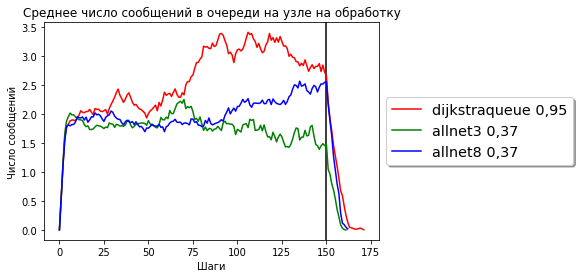

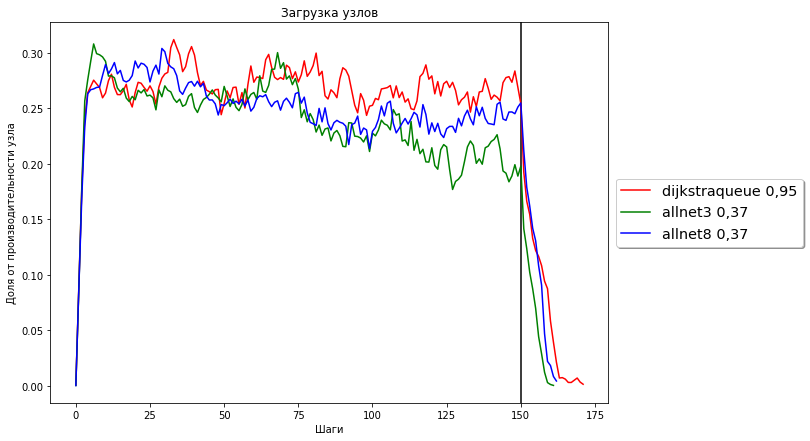

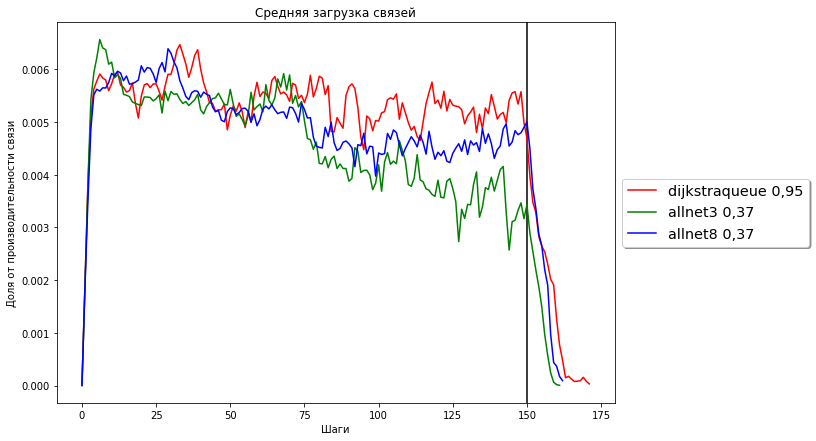

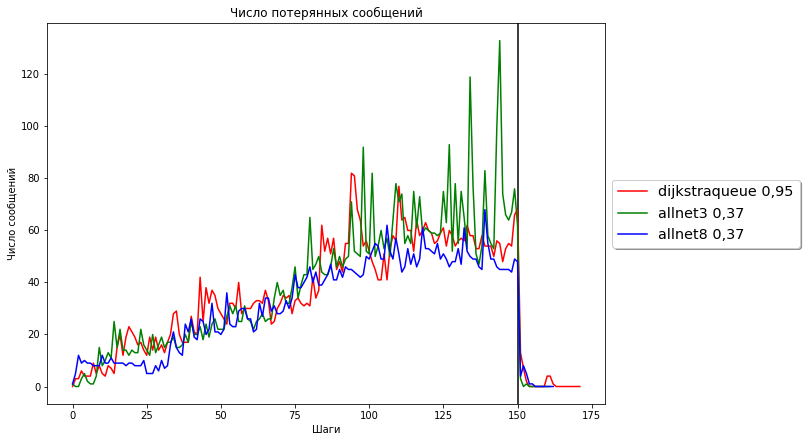

Доставлено 9267 Потеряно 38.2241% -dijkstraqueue 0,95
Доставлено 8925 Потеряно 40.5040% -allnet3 0,37
Доставлено 10021 Потеряно 33.1978% -allnet8 0,37


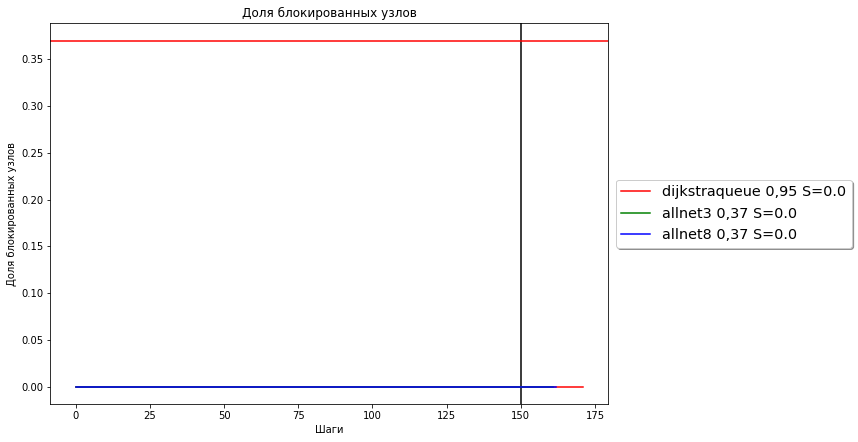

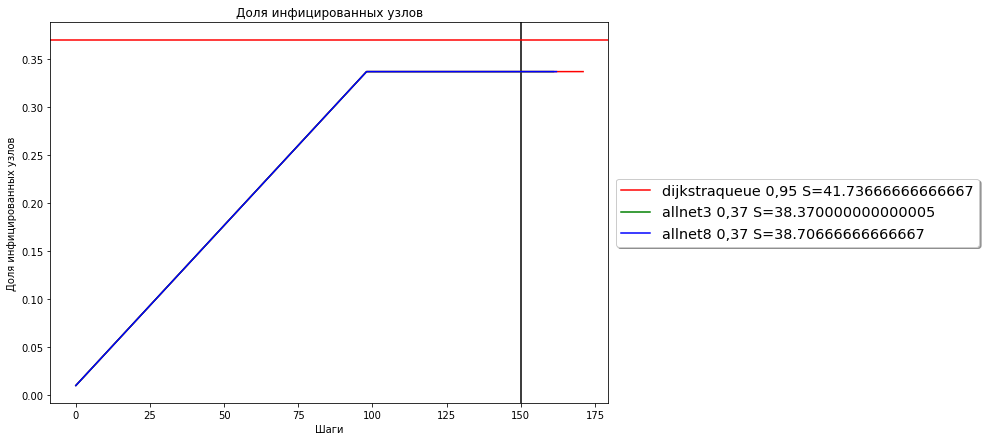

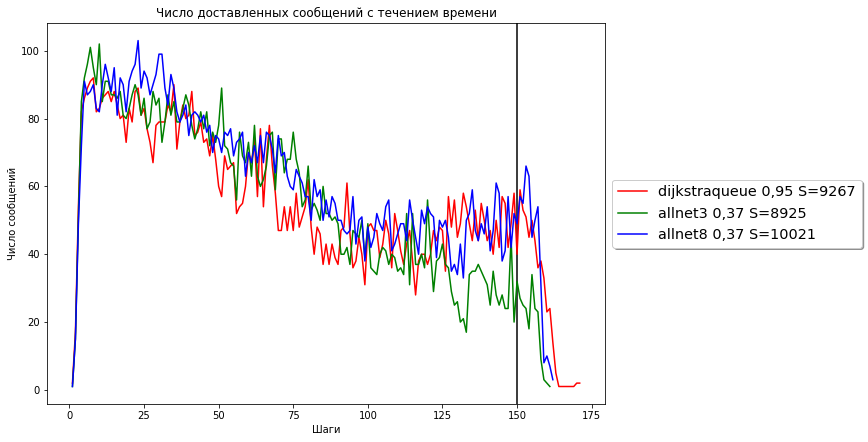

In [2]:
quantity = 100;
log_tags = [
{"tag":  "1c75b1c3-e2a8-4b9d-93b7-ca3e964a2590", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "d71e780e-dd2f-4bb6-be3c-649efba27bf5", "label": "allnet3 0,37", "color": "green"},
{"tag":  "abf3e8f0-abf5-4f54-ac85-ba69e0f7df40", "label": "allnet8 0,37", "color": "blue"},
]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

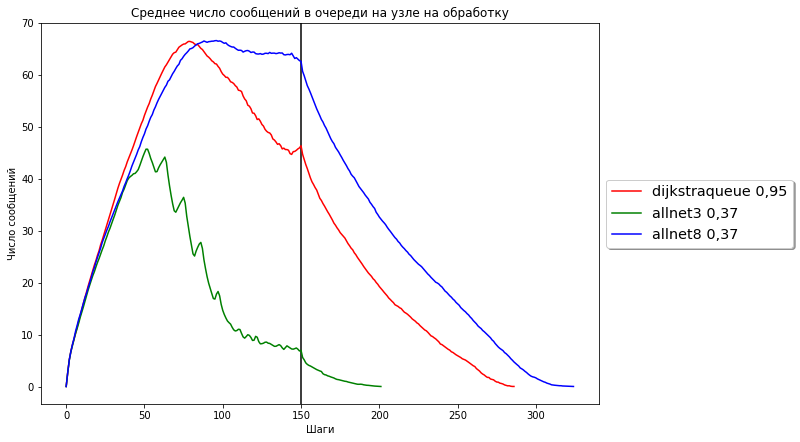

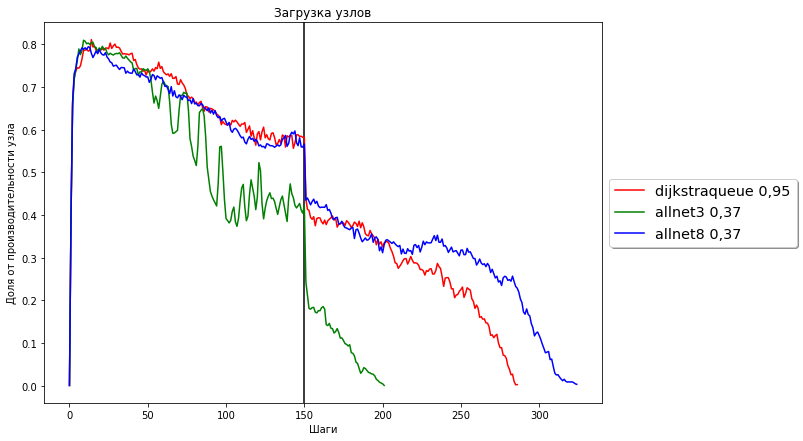

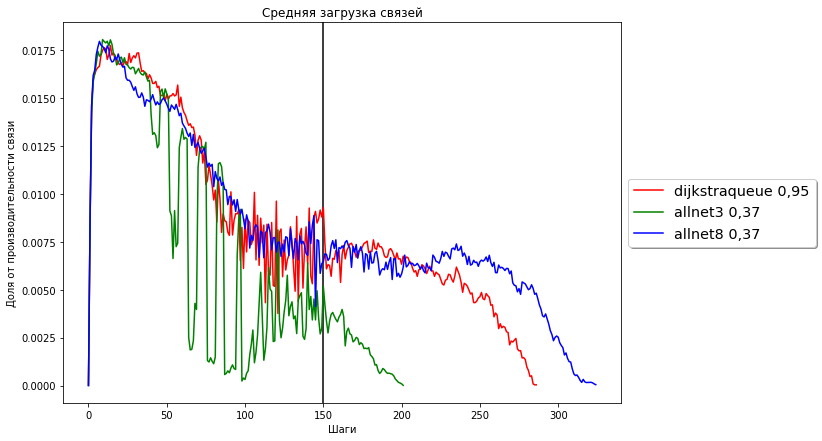

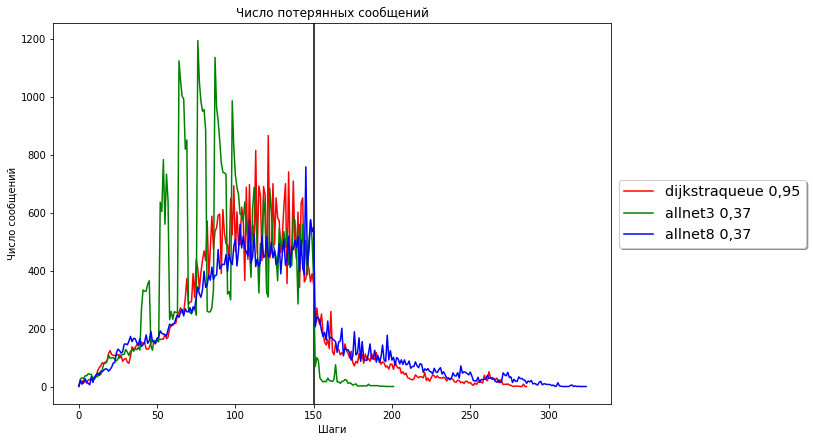

Доставлено 16515 Потеряно 77.9803% -dijkstraqueue 0,95
Доставлено 12290 Потеряно 83.6136% -allnet3 0,37
Доставлено 19474 Потеряно 74.0350% -allnet8 0,37


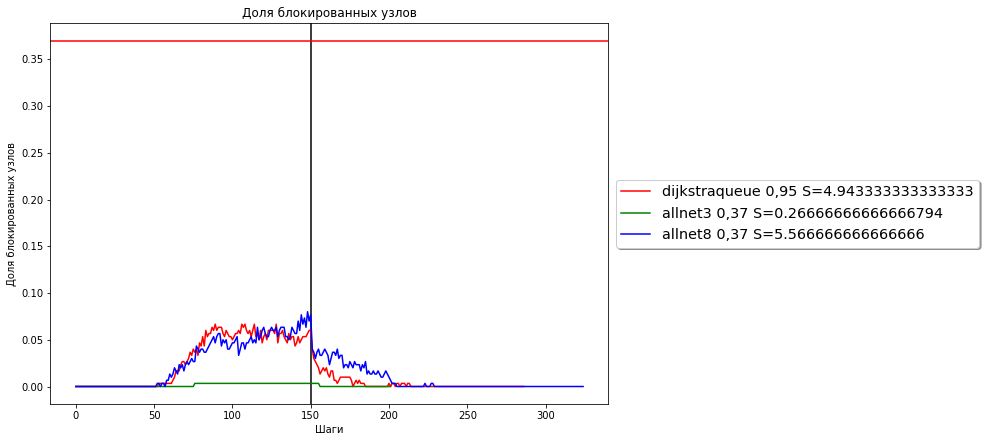

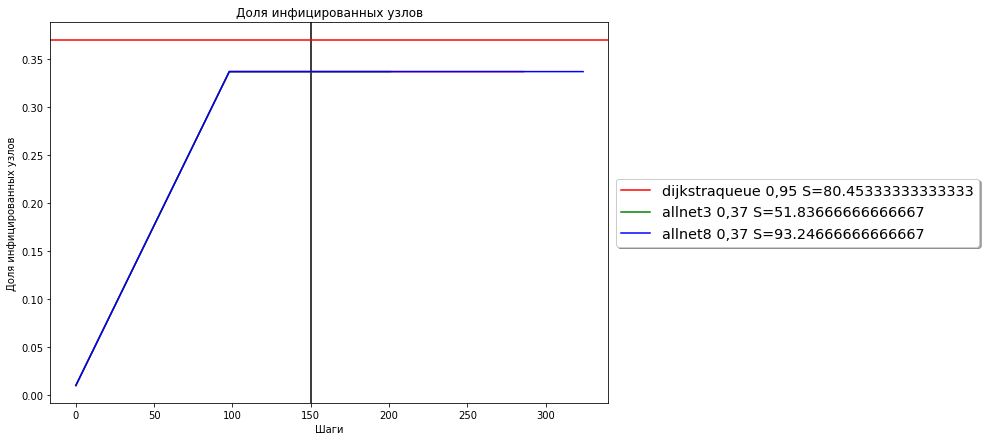

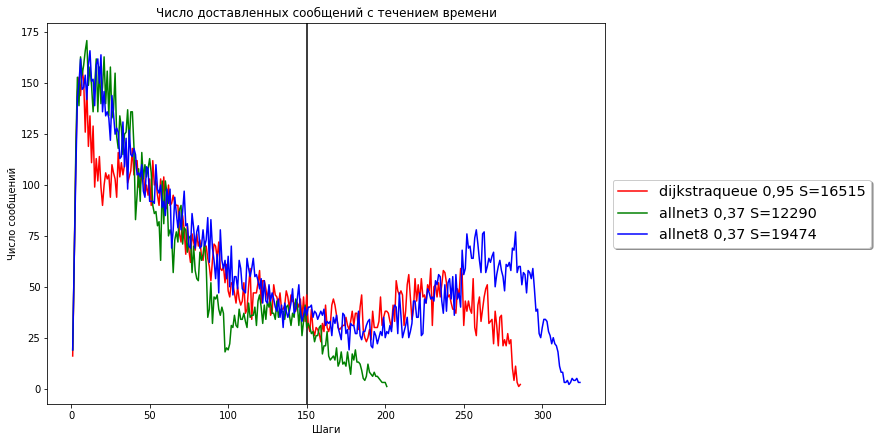

In [3]:
quantity = 500;
log_tags = [
{"tag":  "879fb35c-8fc8-49b9-ba5b-e8341d59bc30", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "9b0d809c-e099-4bc1-ac34-3c62e030236a", "label": "allnet3 0,37", "color": "green"},
{"tag":  "0106f278-9dd7-4238-b21d-3e61c5e616a3", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

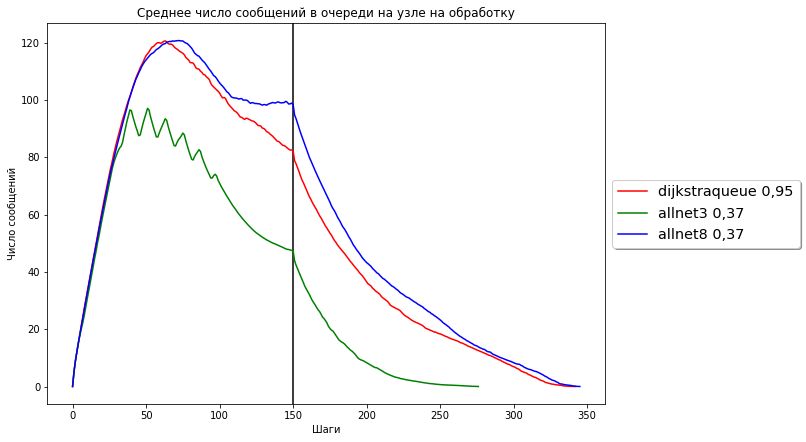

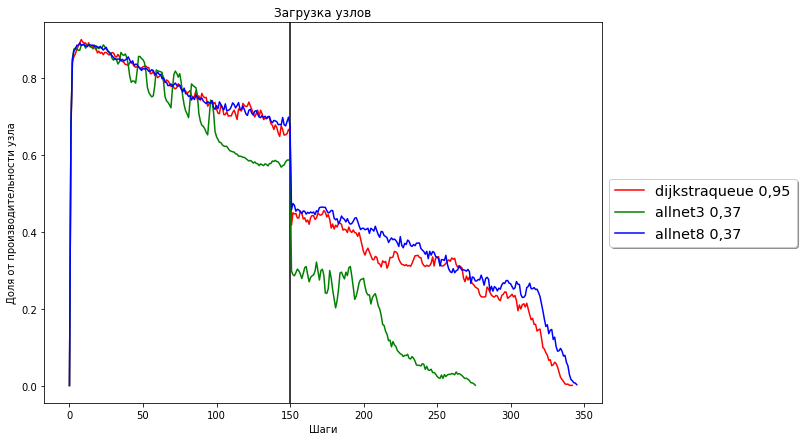

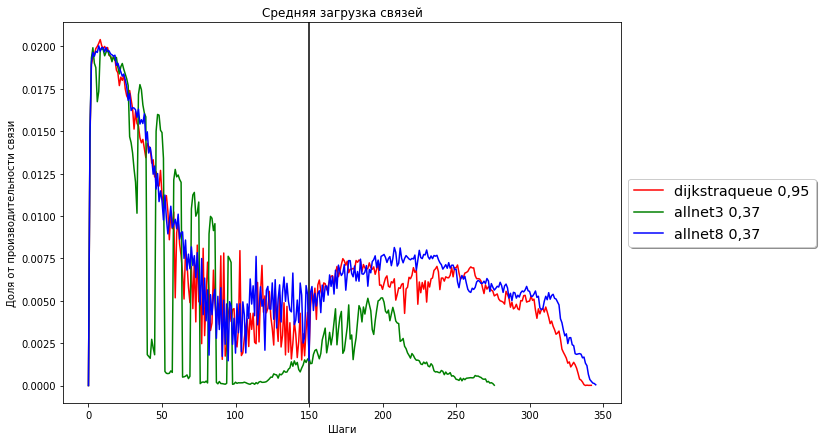

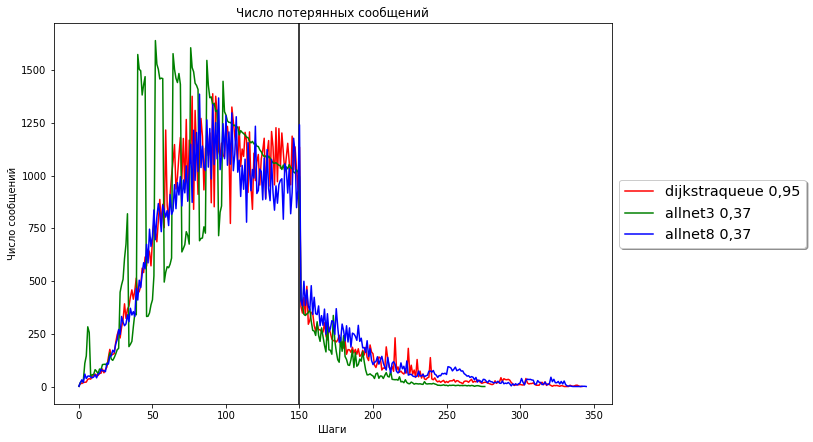

Доставлено 13541 Потеряно 90.9727% -dijkstraqueue 0,95
Доставлено 8363 Потеряно 94.4247% -allnet3 0,37
Доставлено 15887 Потеряно 89.4087% -allnet8 0,37


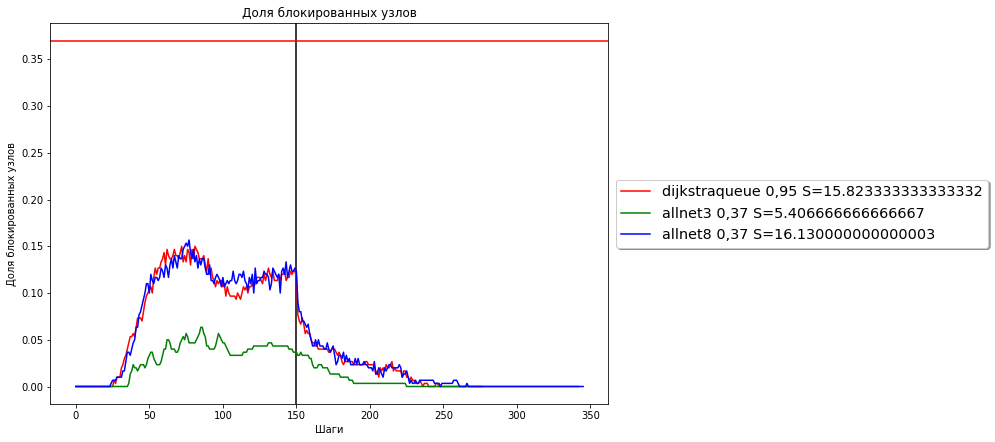

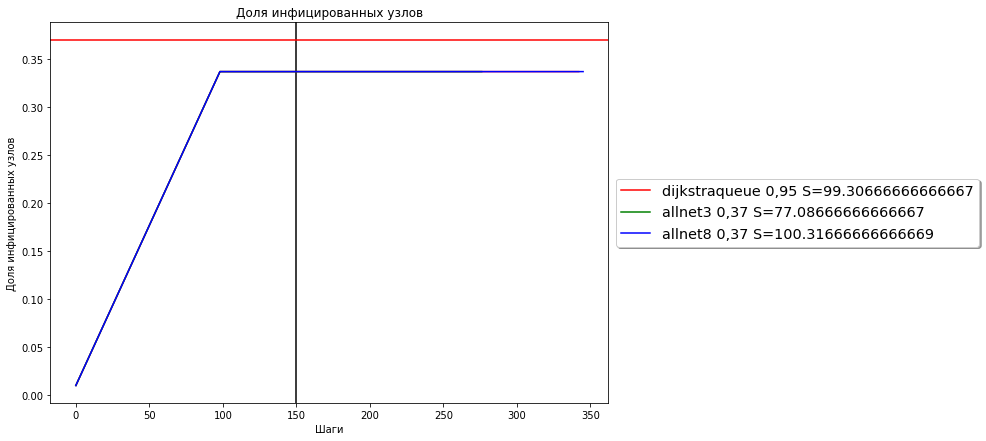

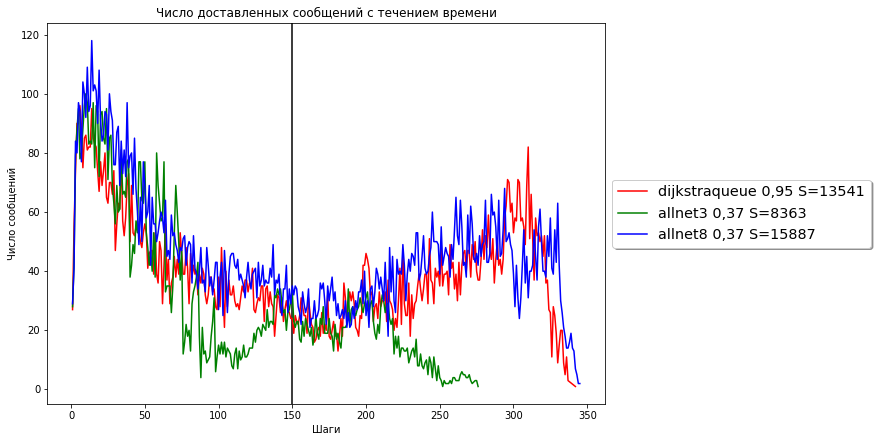

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "f5871349-b206-4824-b439-164442fb98c0", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "f0e82cb1-15b1-4dd0-b9c8-dd2ecb85d0fb", "label": "allnet3 0,37", "color": "green"},
{"tag":  "ba8095b8-b973-4162-8487-a3ab042bb1fd", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

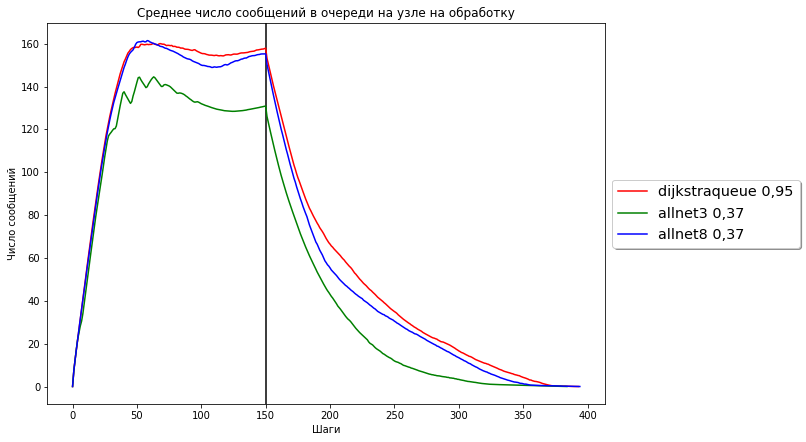

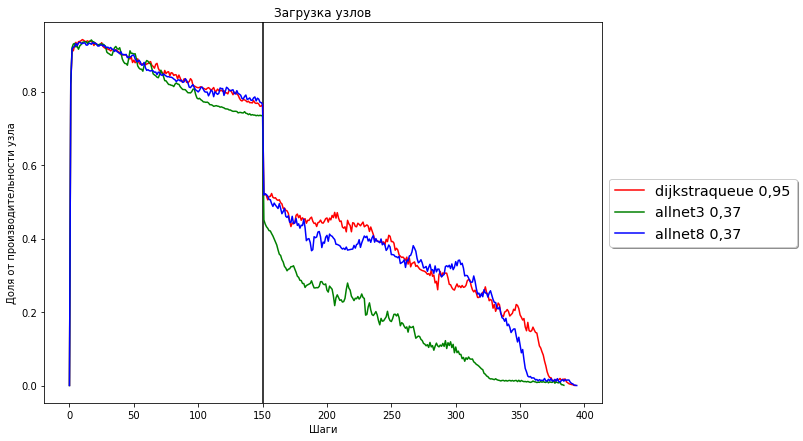

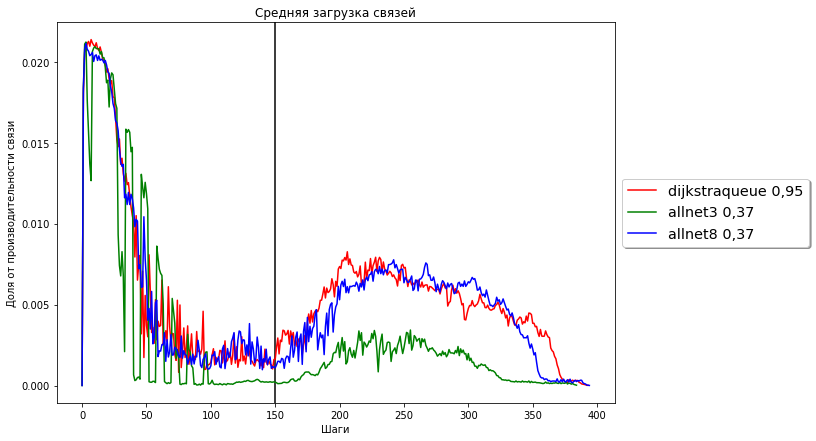

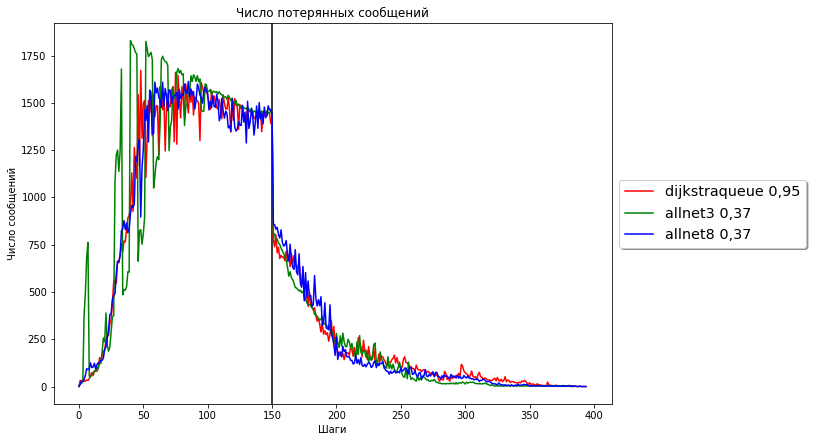

Доставлено 11999 Потеряно 94.6671% -dijkstraqueue 0,95
Доставлено 6367 Потеряно 97.1702% -allnet3 0,37
Доставлено 13576 Потеряно 93.9662% -allnet8 0,37


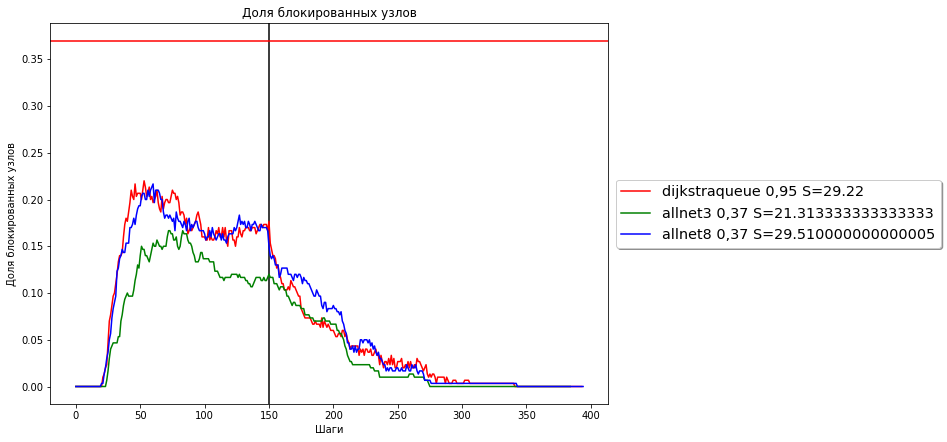

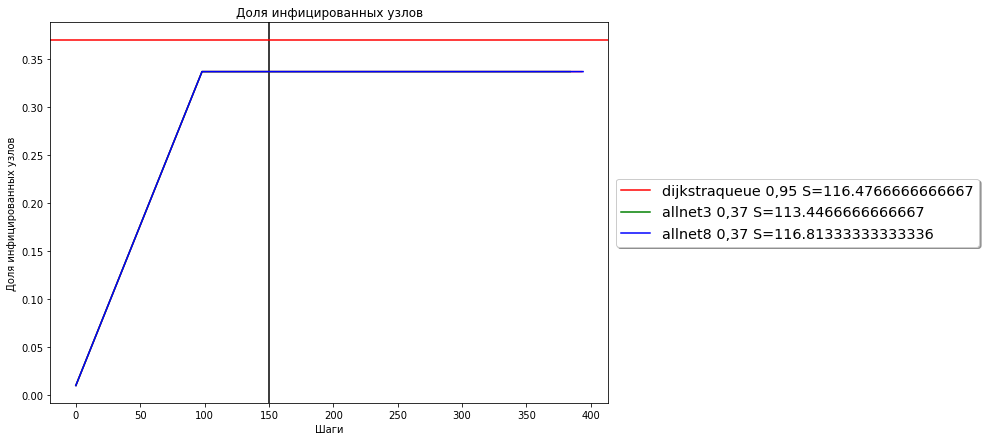

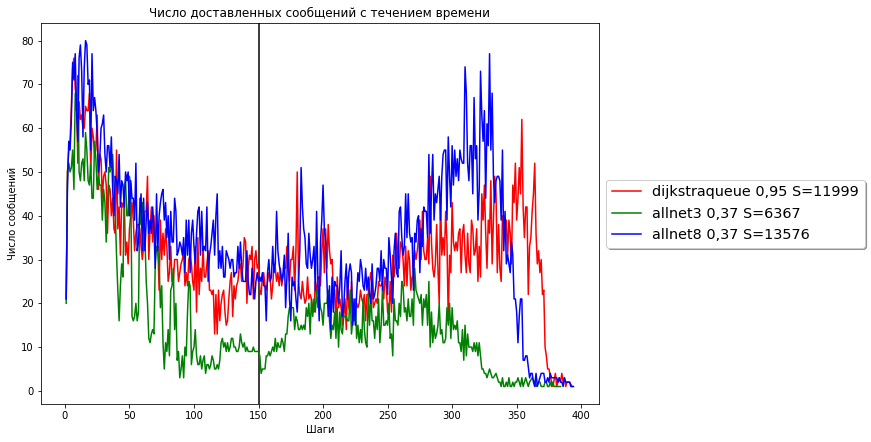

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "ef1792c0-b98a-4b85-a158-0151e384f7e1", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "0abce2f2-9785-41e7-80af-b903be450949", "label": "allnet3 0,37", "color": "green"},
{"tag":  "6c8e672a-4ce4-4542-aa5d-67756d3df083", "label": "allnet8 0,37", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 16156 Потеряно 64.0986% -dijkstraqueue 0,95
Доставлено 12485 Потеряно 72.2562% -allnet3 0,37
Доставлено 17573 Потеряно 60.9498% -allnet8 0,37


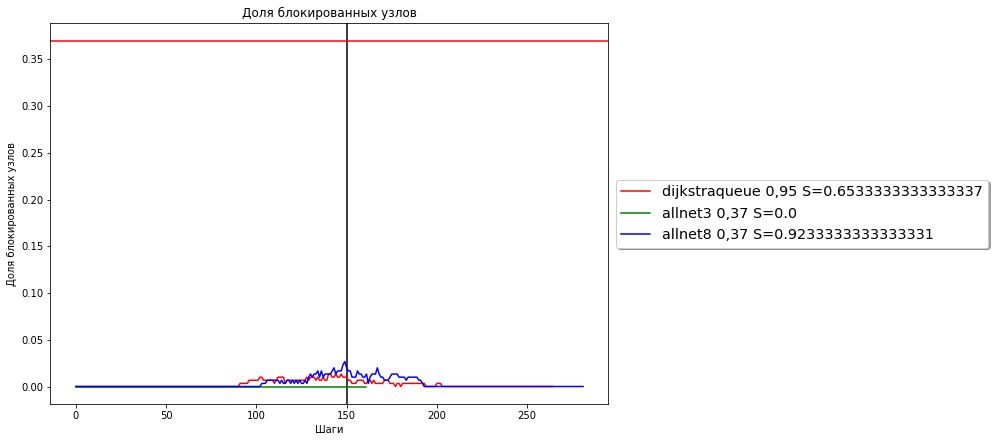

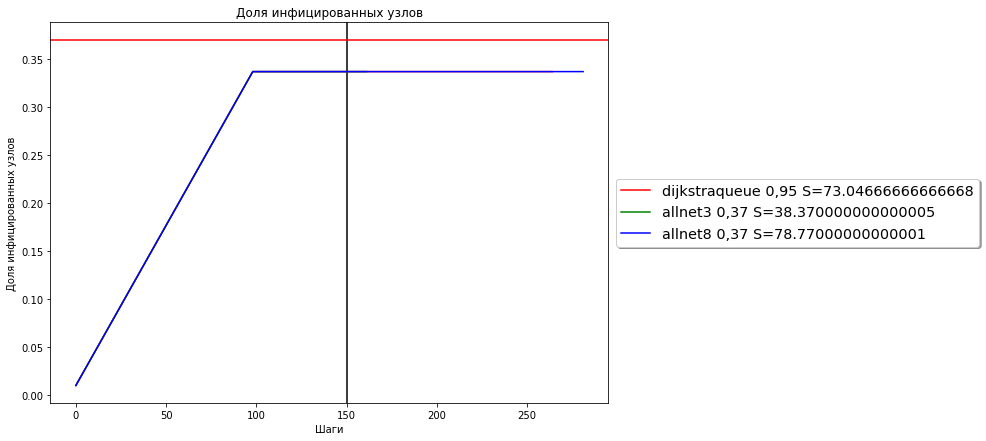

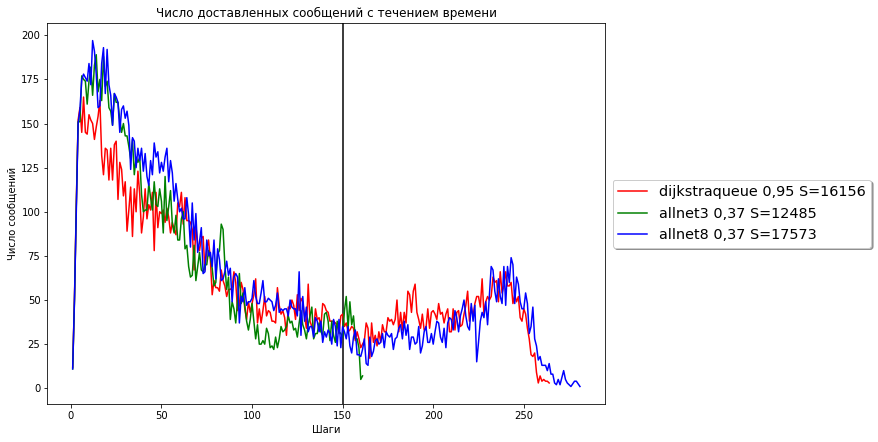

Доставлено 15262 Потеряно 85.4649% -dijkstraqueue 0,95
Доставлено 9653 Потеряно 90.8068% -allnet3 0,37
Доставлено 16460 Потеряно 84.3240% -allnet8 0,37


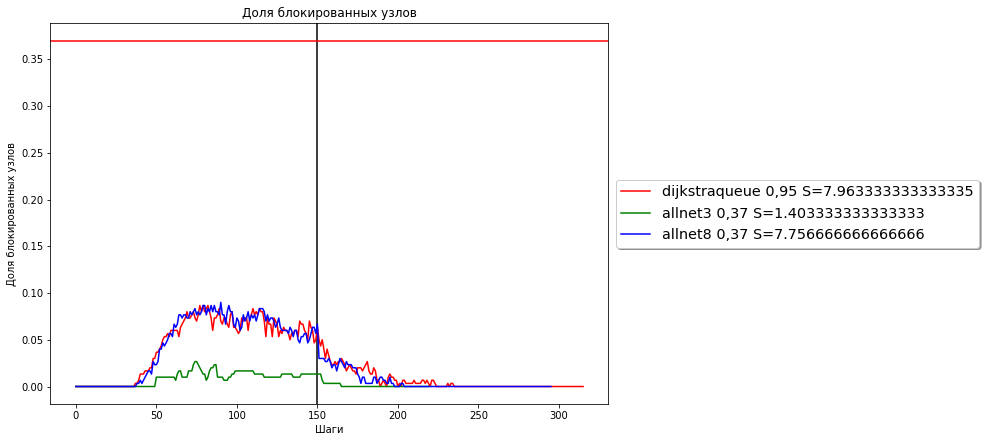

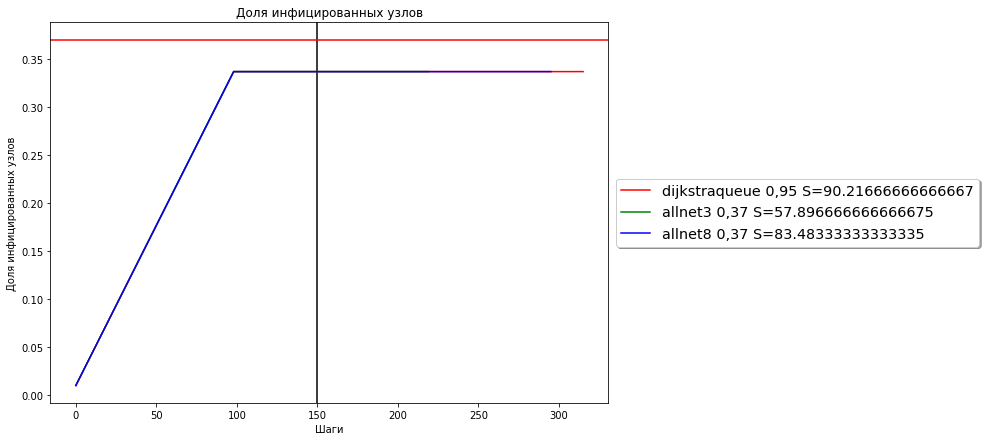

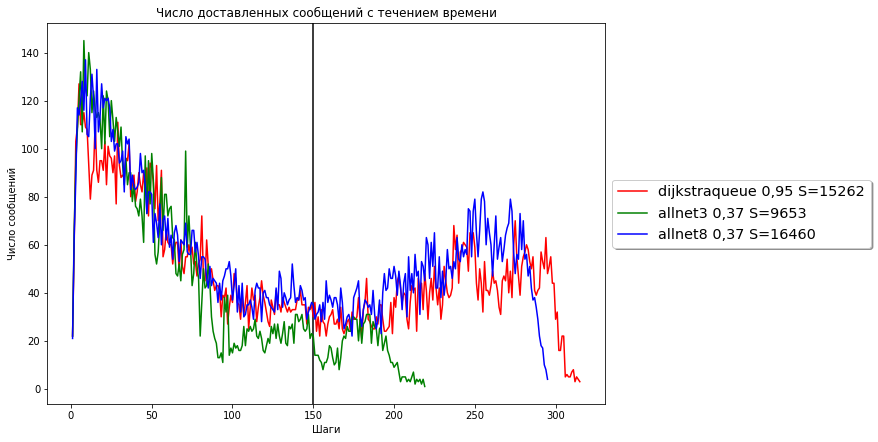

Доставлено 15124 Потеряно 88.7971% -dijkstraqueue 0,95
Доставлено 9341 Потеряно 93.0808% -allnet3 0,37
Доставлено 14484 Потеряно 89.2712% -allnet8 0,37


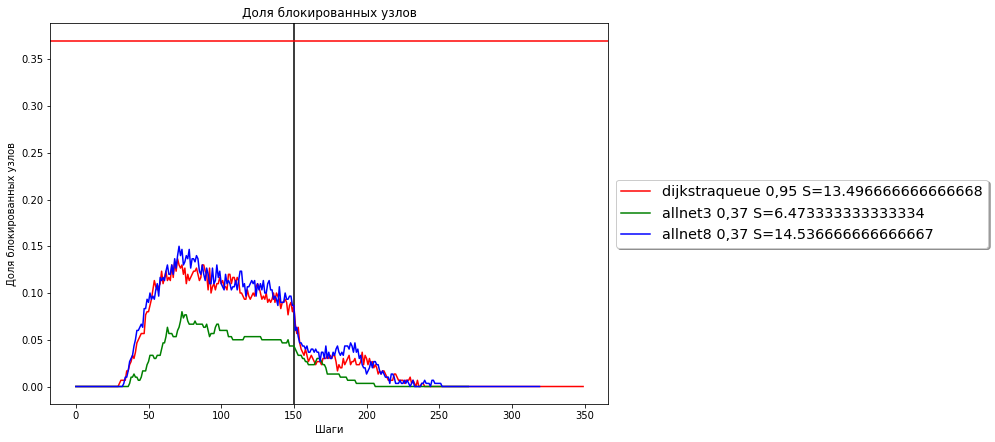

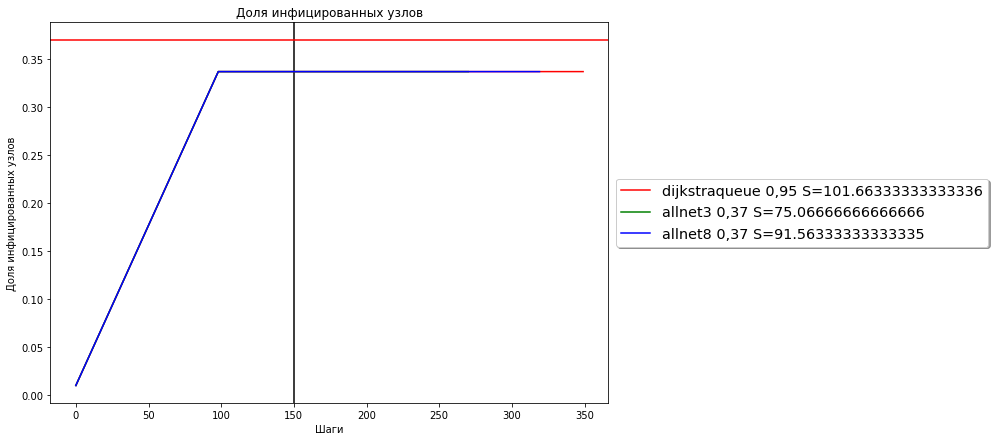

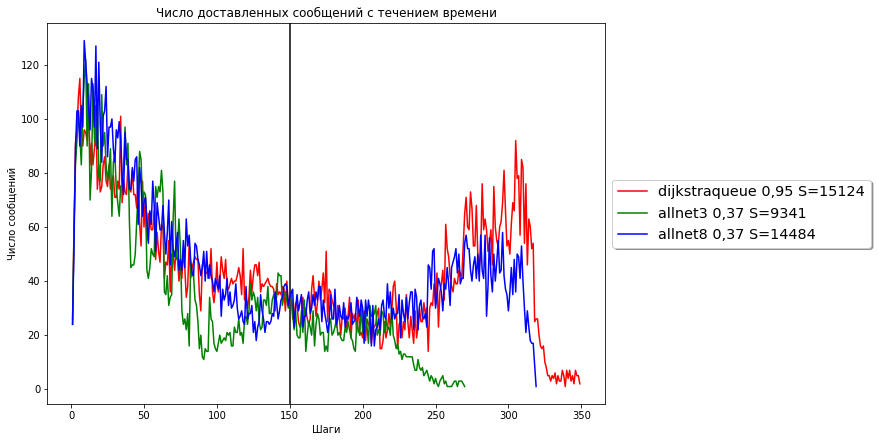

Доставлено 13260 Потеряно 93.2000% -dijkstraqueue 0,95
Доставлено 7493 Потеряно 96.1575% -allnet3 0,37
Доставлено 15056 Потеряно 92.2790% -allnet8 0,37


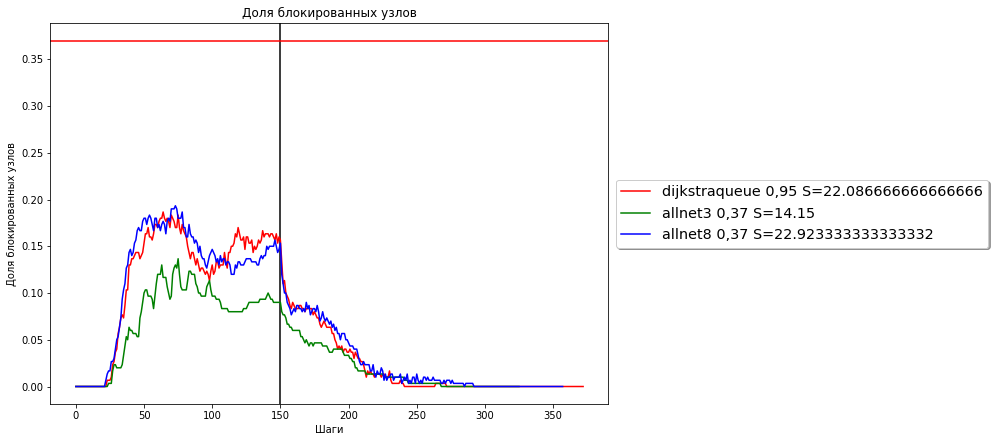

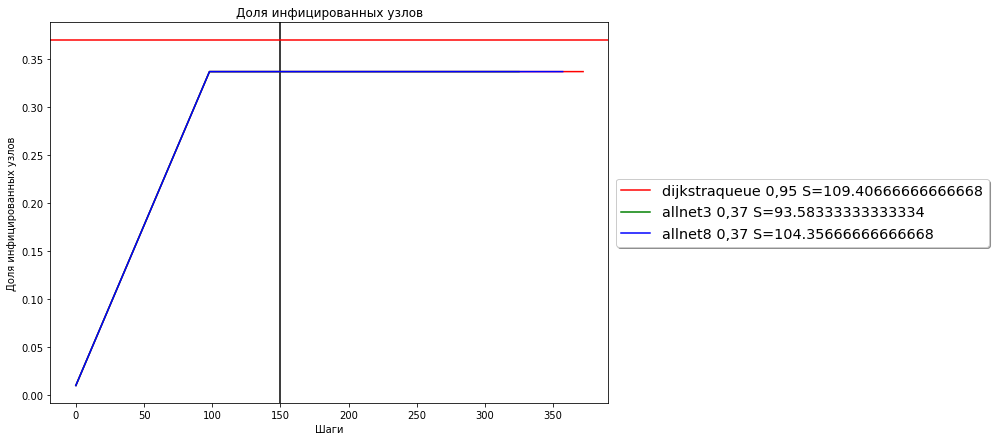

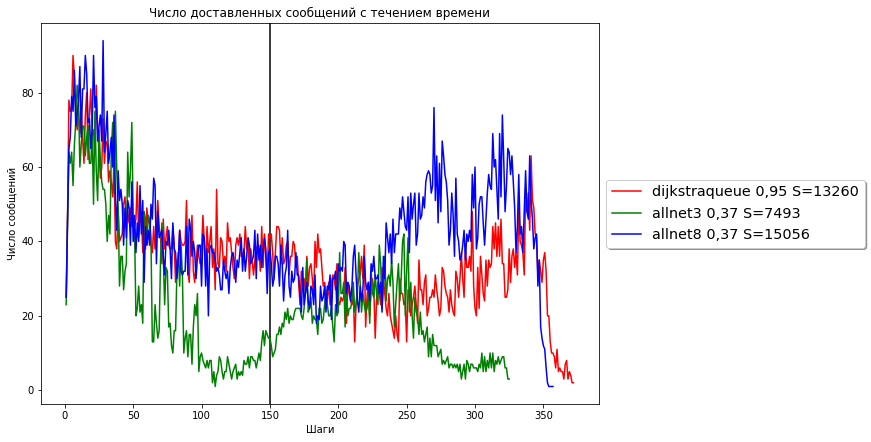

In [6]:
quantity = 300;
log_tags = [
{"tag":  "ea166358-e31f-40f2-b5eb-d7083102a6de", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "68ab7a92-0658-4e22-91d4-721fb49671a1", "label": "allnet3 0,37", "color": "green"},
{"tag":  "f468153f-17eb-430a-a0b2-a54dbbc2fce7", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "2939d9b8-459b-46da-b65a-f6b7fc9ba1c9", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "111da417-ee3a-4fc3-852d-d4faff60c38a", "label": "allnet3 0,37", "color": "green"},
{"tag":  "264dd85d-2df9-434c-9838-68c950b40f54", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "6d3dca5c-f4a0-4fc9-b927-e00de5b5a254", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "5fb42535-9dfa-4ff1-8773-44bfd1a31e8c", "label": "allnet3 0,37", "color": "green"},
{"tag":  "cd373c95-d160-47b5-87c3-1d2672f2d684", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "2c55ec89-78c0-4941-9690-33aaa4ec1256", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "fa97889b-6ee0-42b8-b435-4a6b7c3f95c8", "label": "allnet3 0,37", "color": "green"},
{"tag":  "c85918e2-a684-4487-915f-abe53179eeab", "label": "allnet8 0,37", "color": "blue"},
]
showStatBlocked();
showStatMessage();

      dijkstraqueue 0,95  allnet3 0,37  allnet8 0,37
100             5.826612      3.415439      4.108859
300            27.624586      9.336304     29.411635
500            36.110465     13.199117     44.822136
700            39.017581     17.050647     39.194189
900            40.103858     21.013978     37.298576
1000           36.375297     22.464604     39.373391
1300           37.585823     27.732555     37.053748
1500           39.911658     31.229190     37.944765


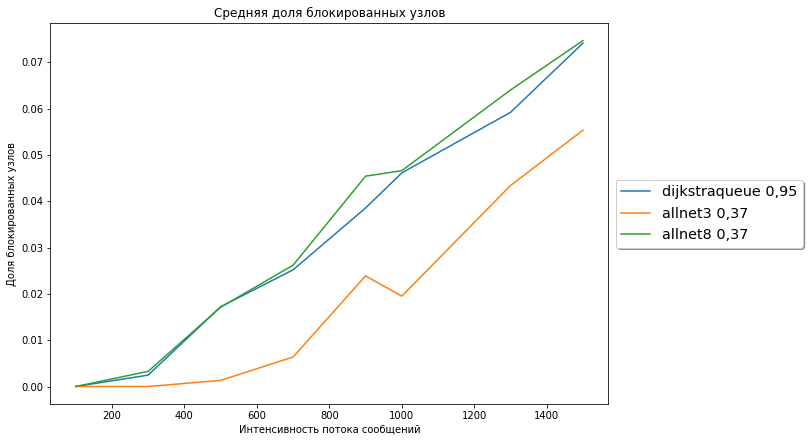

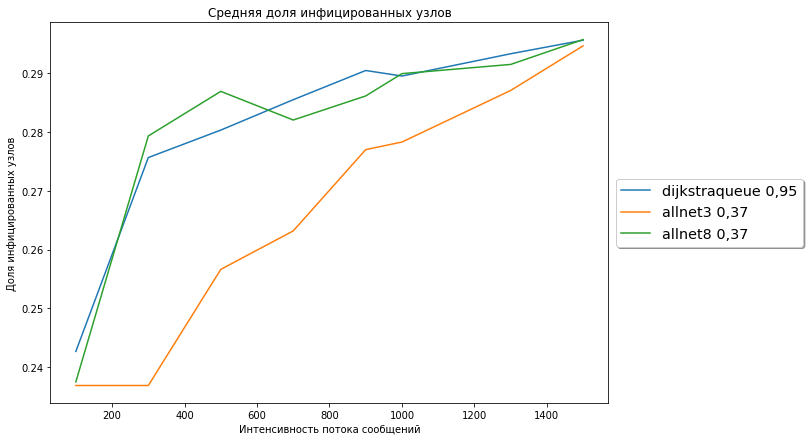

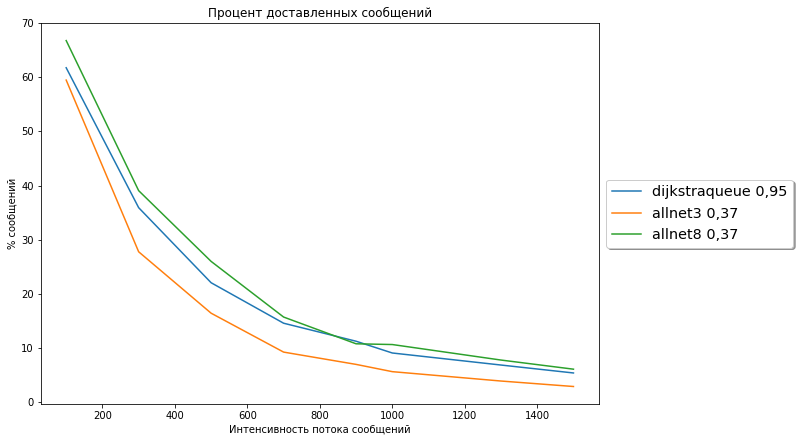

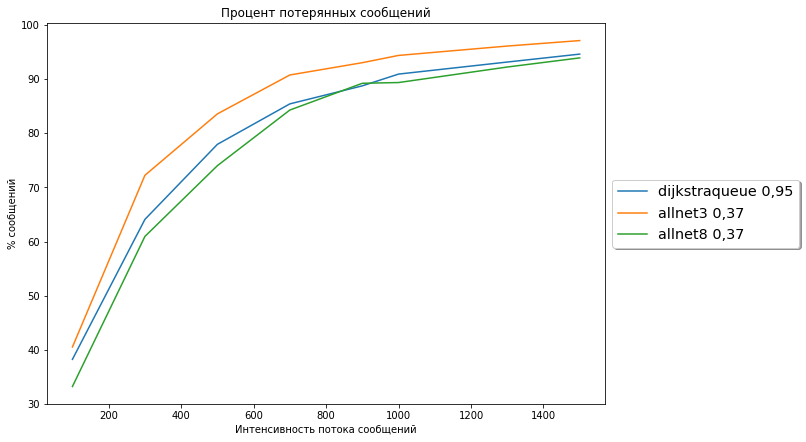

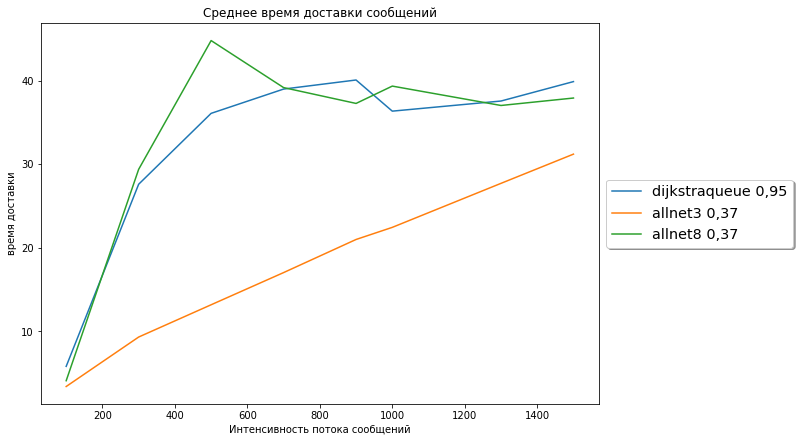

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()
print (MessageTimeSpent)

In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.032870
allnet3 0,37          0.018734
allnet8 0,37          0.034674

dijkstraqueue 0,95    79.175613
allnet3 0,37          83.501704
allnet8 0,37          77.178963

dijkstraqueue 0,95    32.819485
allnet3 0,37          18.180229
allnet8 0,37          33.650912

dijkstraqueue 0,95    0.281632
allnet3 0,37          0.266314
allnet8 0,37          0.281130
